<a href="https://colab.research.google.com/github/md-abu-shayid/Brain_Tumor_Detection_CNN/blob/main/Ensemble_Learning_Grid_Search_(99_16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

print('Data source import complete.')


In [ ]:

# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy


# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
classes=[]
filename='/kaggle/input/brain-tumor-mri-dataset'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)

['pituitary', 'notumor', 'meningioma', 'glioma']


In [ ]:
train_path='/kaggle/input/brain-tumor-mri-dataset/Training/'
test_path='/kaggle/input/brain-tumor-mri-dataset/Testing/'

In [ ]:
img_list=[]
label_list=[]
for label in classes:
    for img_file in os.listdir(train_path+label):
        img_list.append(train_path+label+'/'+img_file)
        label_list.append(label)

In [ ]:
train_data = pd.DataFrame({'Image':img_list,'Label':label_list})
train_data

,Image,Label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [ ]:
img_list=[]
label_list=[]
for label in classes:
    for img_file in os.listdir(test_path+label):
        img_list.append(test_path+label+'/'+img_file)
        label_list.append(label)

In [ ]:
test_data = pd.DataFrame({'Image':img_list,'Label':label_list})
test_data

,Image,Label
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


In [ ]:
def Plot_Classes(BASE_URL, Rows=2, Columns=5):
    plt.figure(figsize = (25, 8))

    image_count = 1
    for directory in os.listdir(BASE_URL):
        if directory[0] != '.':
            Max_Random = len(os.listdir(os.path.join(BASE_URL,directory)))
            Random_Number = np.random.randint(0, Max_Random)

            for i, file in enumerate(os.listdir(BASE_URL + directory)):
                if i == Random_Number:
                    fig = plt.subplot(Rows, Columns, image_count)
                    image_count += 1

                    image = plt.imread(BASE_URL + directory + '/' + file)
                    plt.imshow(image)
                    plt.title(directory)
                    break

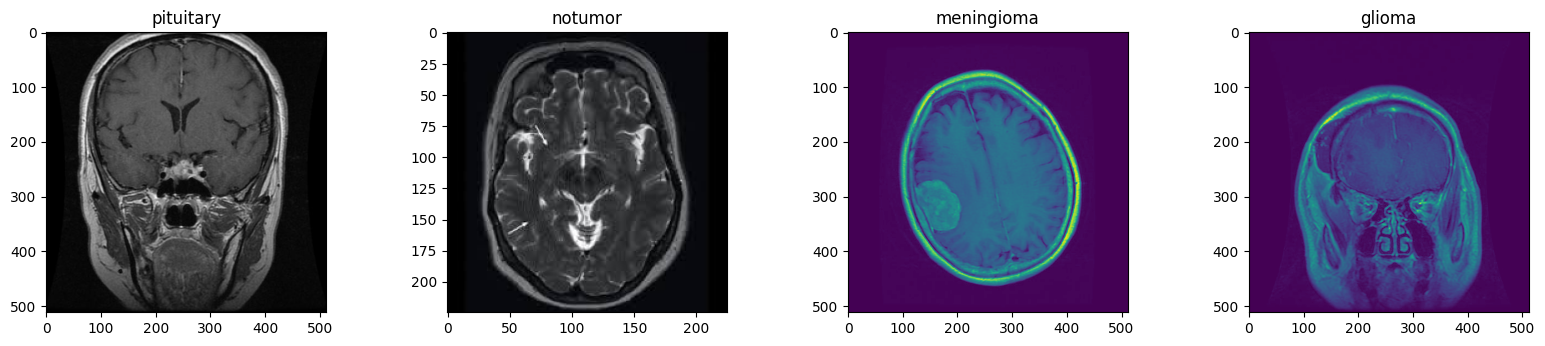

In [ ]:
Plot_Classes(train_path)

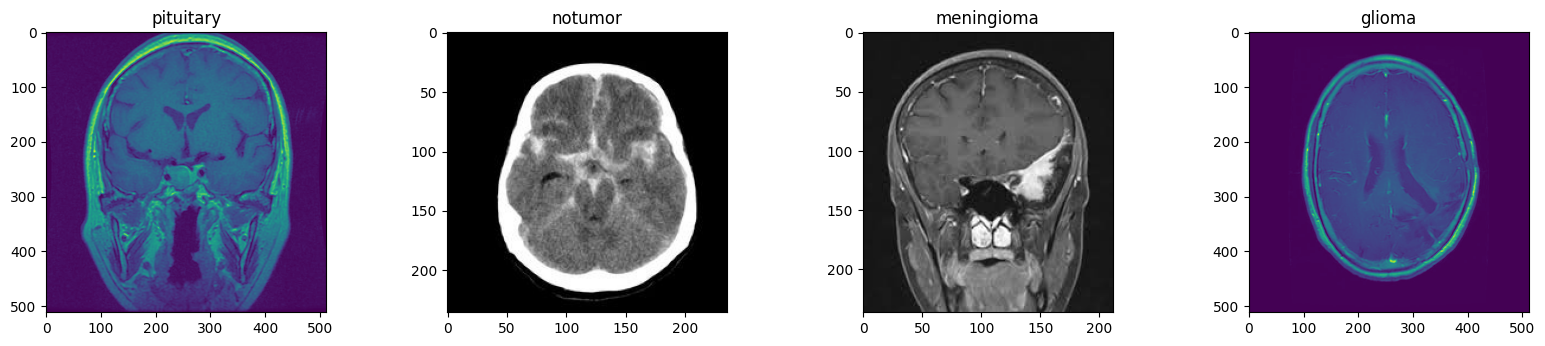

In [ ]:
Plot_Classes(test_path)

In [ ]:
train_data['Label'].value_counts()

Label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

In [ ]:
test_data['Label'].value_counts()

Label
notumor       405
meningioma    306
pituitary     300
glioma        300
Name: count, dtype: int64

# Data Preprocessing

In [ ]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.15,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

# Creating training data generator
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    seed=0)

# Creating validation data generator
val_generator = val_datagen.flow_from_directory(train_path,
                                                target_size=image_size,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation',
                                                seed=0)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=0)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    # Use __next__() instead of next()
    augmented_samples = train_generator.__next__()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()

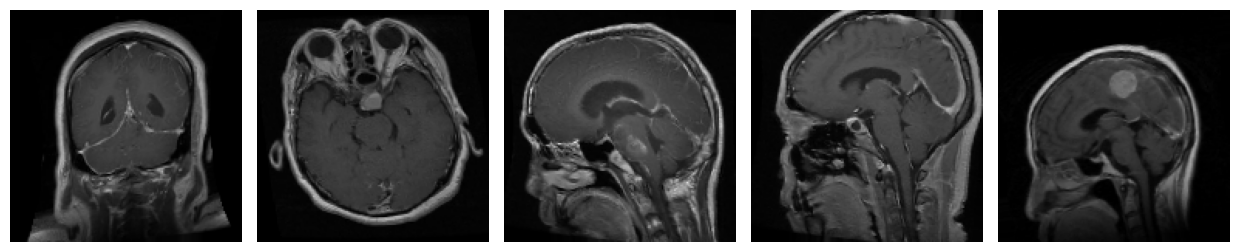

In [ ]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=False)

Training Setup

In [ ]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)


print(f'Image shape: {image_shape}')
print(f'Batch size: {batch_size}')
print(f'Number of Train batches: {len(train_generator)}')
print(f'Number of Validation batches: {len(val_generator)}')
print(f'Number of Testing batches: {len(test_generator)}')

Image shape: (150, 150, 3)
Batch size: 32
Number of Train batches: 152
Number of Validation batches: 27
Number of Testing batches: 41


In [ ]:
Classes_Map = train_generator.class_indices
num_classes = len(Classes_Map)

print("Number of Classes:", num_classes)
Classes_Map

Number of Classes: 4


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [ ]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(15,5))
  plt.style.use('ggplot')


  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
  plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
  plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.style.use('default')

In [ ]:
def CM(model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    print(f"Classification Report for {model}:")
    print(classification_report(true_categories, predicted_categories, target_names=categories))

    return confusion_matrix_array


def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

# InceptionV3

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
from keras.applications.inception_v3 import InceptionV3



base_model_inception = InceptionV3(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150, 150, 3)
)

base_model_inception.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#for layer in base_model_inception.layers[-10:]:
    #layer.trainable = True

# Add custom classification head
x = base_model_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model_inception = Model(inputs=base_model_inception.input, outputs=output)

In [ ]:
model_inception.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 22,853,924 (87.18 MB)

 Trainable params: 1,051,332 (4.01 MB)

 Non-trainable params: 21,802,592 (83.17 MB)

In [ ]:
model_inception.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
inception_history = model_inception.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 57s 291ms/step - accuracy: 0.5831 - loss: 1.2192 - val_accuracy: 0.7041 - val_loss: 0.8023
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.8054 - loss: 0.5161 - val_accuracy: 0.7345 - val_loss: 0.6782
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - accuracy: 0.8347 - loss: 0.4493 - val_accuracy: 0.7778 - val_loss: 0.5844
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 223ms/step - accuracy: 0.8540 - loss: 0.3860 - val_accuracy: 0.7895 - val_loss: 0.5699
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 224ms/step - accuracy: 0.8686 - loss: 0.3487 - val_accuracy: 0.8047 - val_loss: 0.5257
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 224ms/step - accuracy: 0.8648 - loss: 0.3509 - val_accuracy: 0.8164 - val_loss: 0.5313
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 224ms/step - accuracy: 0.8877 - loss: 0.3082 - val_accuracy: 0.7988 - val_loss: 0.5561
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step - accuracy: 0.8896 - loss: 0

In [ ]:
model_inception.save('model_inception.h5')

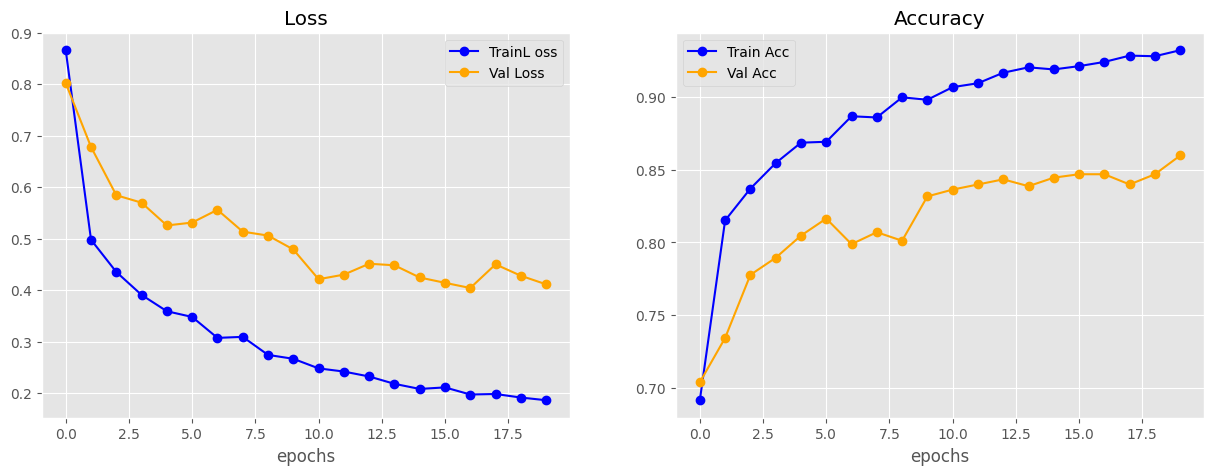

In [ ]:
plot_curves(inception_history)

In [ ]:
loss, accuracy = model_inception.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.8498 - loss: 0.3749
Test Loss: 0.25653
Test Accuracy: 0.90313


# Xception

In [ ]:
from keras.applications.xception import Xception


base_model_xception = Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150, 150, 3)
)

base_model_xception.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model_xception.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model_xception = Model(inputs=base_model_xception.input, outputs=output)

In [ ]:
model_xception.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        512 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add[0][0]       

 Total params: 23,550,636 (89.84 MB)

 Trainable params: 8,185,476 (31.23 MB)

 Non-trainable params: 15,365,160 (58.61 MB)

In [ ]:
model_xception.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
xception_history = model_xception.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 66s 342ms/step - accuracy: 0.6750 - loss: 0.8128 - val_accuracy: 0.8503 - val_loss: 0.5969
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 41s 261ms/step - accuracy: 0.9111 - loss: 0.2471 - val_accuracy: 0.8678 - val_loss: 0.4363
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 43s 271ms/step - accuracy: 0.9375 - loss: 0.1826 - val_accuracy: 0.9099 - val_loss: 0.2655
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 43s 270ms/step - accuracy: 0.9540 - loss: 0.1246 - val_accuracy: 0.9135 - val_loss: 0.2502
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 42s 264ms/step - accuracy: 0.9608 - loss: 0.1145 - val_accuracy: 0.9415 - val_loss: 0.2046
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 42s 265ms/step - accuracy: 0.9733 - loss: 0.0768 - val_accuracy: 0.9298 - val_loss: 0.2226
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 296ms/step - accuracy: 0.9726 - loss: 0.0699 - val_accuracy: 0.9368 - val_loss: 0.2623
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 301ms/step - accuracy: 0.9773 - loss: 0

In [ ]:
model_xception.save('model_xception.h5')

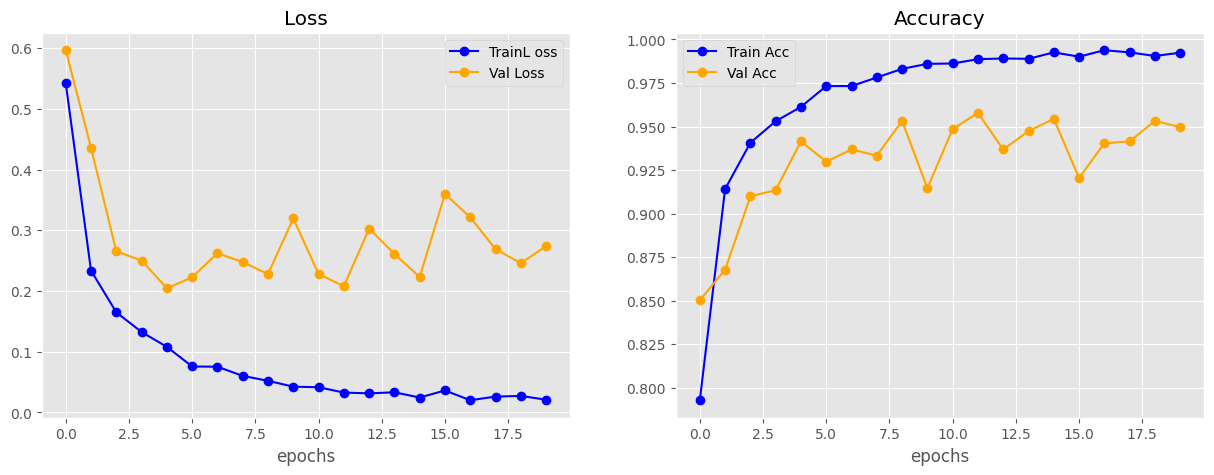

In [ ]:
plot_curves(xception_history)

In [ ]:
loss, accuracy = model_xception.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9726 - loss: 0.0973
Test Loss: 0.09128
Test Accuracy: 0.97254


# CNN Model

In [ ]:
def create_cnn_model(input_shape=image_shape, num_classes=num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()

In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_98 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,660 (13.18 MB)

 Trainable params: 3,454,660 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history = cnn_model.fit(train_generator,epochs=30,validation_data=val_generator)

Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 265ms/step - accuracy: 0.5205 - loss: 1.0265 - val_accuracy: 0.7193 - val_loss: 0.6813
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 221ms/step - accuracy: 0.7875 - loss: 0.5336 - val_accuracy: 0.8152 - val_loss: 0.5526
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 218ms/step - accuracy: 0.8287 - loss: 0.4312 - val_accuracy: 0.8023 - val_loss: 0.5659
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 221ms/step - accuracy: 0.8608 - loss: 0.3696 - val_accuracy: 0.8269 - val_loss: 0.4748
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 218ms/step - accuracy: 0.8804 - loss: 0.3034 - val_accuracy: 0.8327 - val_loss: 0.5120
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.8995 - loss: 0.2653 - val_accuracy: 0.8690 - val_loss: 0.3889
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 0.9155 - loss: 0.2240 - val_accuracy: 0.8971 - val_loss: 0.3672
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.9189 - loss: 0

In [ ]:
cnn_model.save('cnn_model.h5')

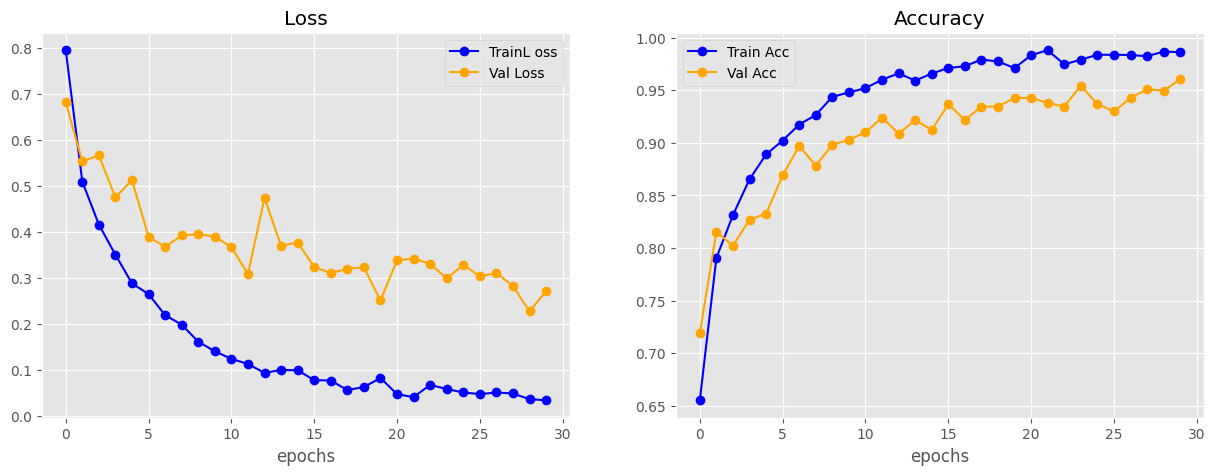

In [ ]:
plot_curves(cnn_history)

In [ ]:
loss, accuracy = cnn_model.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9705 - loss: 0.1674
Test Loss: 0.12378
Test Accuracy: 0.97864


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step
Classification Report for <Sequential name=sequential, built=True>:
              precision    recall  f1-score   support

   pituitary       0.99      0.97      0.98       300
     notumor       0.97      0.95      0.96       306
  meningioma       0.98      1.00      0.99       405
      glioma       0.97      0.99      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



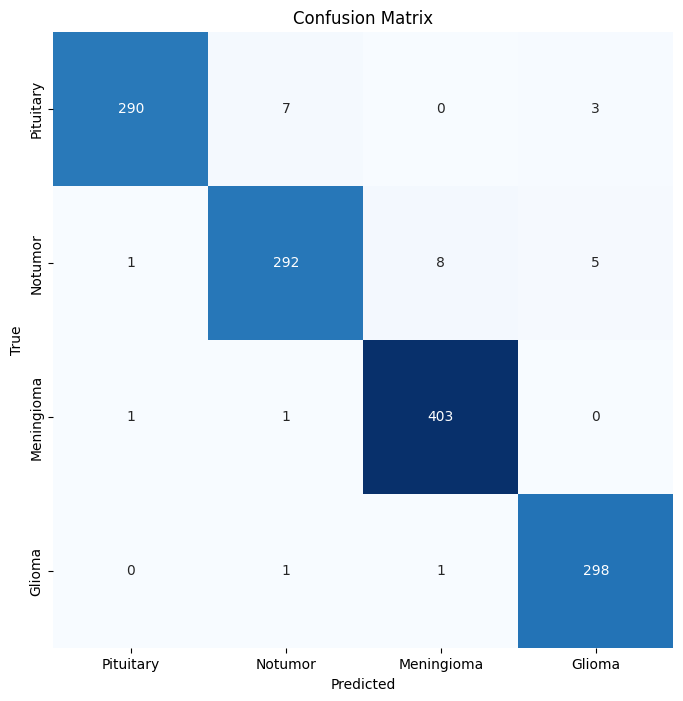

In [ ]:
# Plotting confusion matrix
confusion_matrix = CM(model=cnn_model, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

# VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


for layer in base_model_vgg.layers[:-10]:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model_vgg.layers[-10:]:
    layer.trainable = True

# Add custom classification head
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model_vgg = Model(inputs=base_model_vgg.input, outputs=output)

In [ ]:
model_vgg.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 13,833,988 (52.77 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [ ]:
model_vgg.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
vgg_history = model_vgg.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 290ms/step - accuracy: 0.6726 - loss: 0.7844 - val_accuracy: 0.8678 - val_loss: 0.3845
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 226ms/step - accuracy: 0.9103 - loss: 0.2602 - val_accuracy: 0.8830 - val_loss: 0.3894
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 225ms/step - accuracy: 0.9446 - loss: 0.1605 - val_accuracy: 0.9357 - val_loss: 0.2165
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 225ms/step - accuracy: 0.9589 - loss: 0.1182 - val_accuracy: 0.9158 - val_loss: 0.2550
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 226ms/step - accuracy: 0.9616 - loss: 0.1025 - val_accuracy: 0.8982 - val_loss: 0.3823
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 226ms/step - accuracy: 0.9658 - loss: 0.0977 - val_accuracy: 0.9368 - val_loss: 0.2719
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 225ms/step - accuracy: 0.9725 - loss: 0.0798 - val_accuracy: 0.9228 - val_loss: 0.3530
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 226ms/step - accuracy: 0.9752 - loss: 0

In [ ]:
model_vgg.save('model_vgg.h5')

## VGG16 Evaluation

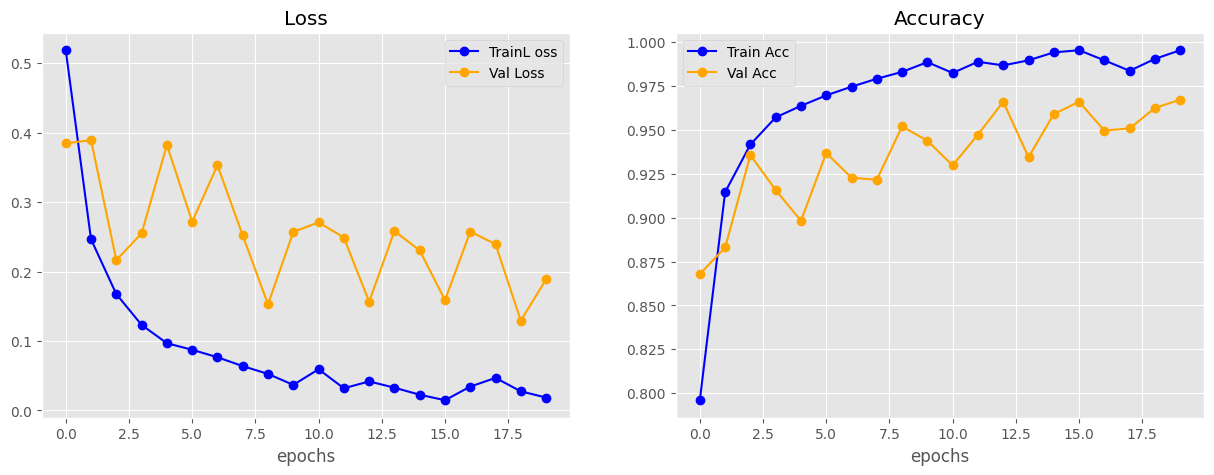

In [ ]:
plot_curves(vgg_history)

In [ ]:
loss, accuracy = model_vgg.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9682 - loss: 0.1547
Test Loss: 0.08413
Test Accuracy: 0.98322


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step
Classification Report for <Functional name=functional_21, built=True>:
              precision    recall  f1-score   support

   pituitary       1.00      0.95      0.97       300
     notumor       0.96      0.99      0.98       306
  meningioma       0.99      1.00      0.99       405
      glioma       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



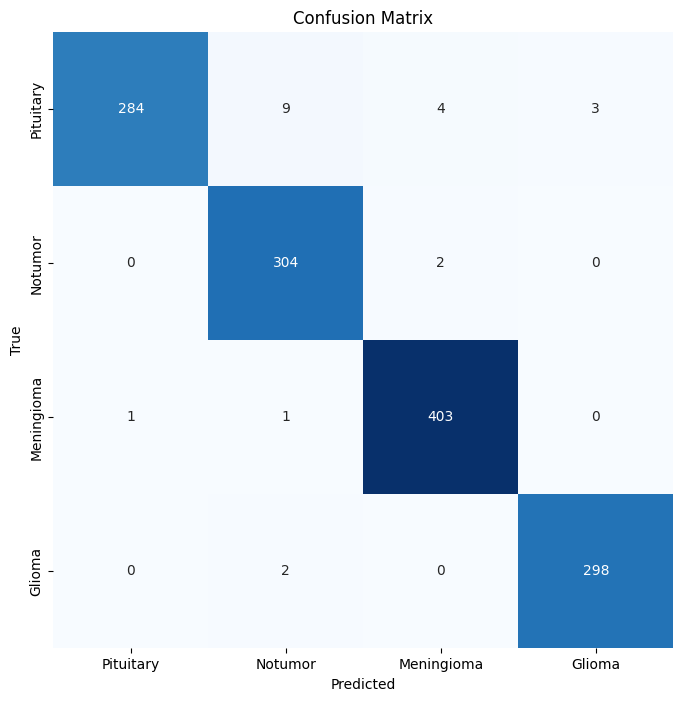

In [ ]:
# Plotting confusion matrix
confusion_matrix = CM(model=model_vgg, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

# ResNet101

In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


base_model_resnet = ResNet101(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:

# for layer in base_model_resnet.layers[:-10]:
#     layer.trainable = False

# for layer in base_model_resnet.layers[-10:]:
#     layer.trainable = True


# Add custom classification head
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=output)

In [ ]:
model_resnet.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 43,709,316 (166.74 MB)

 Trainable params: 43,603,972 (166.34 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [ ]:
model_resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet_history = model_resnet.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20


I0000 00:00:1732849539.691913     150 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_53', 224 bytes spill stores, 224 bytes spill loads



152/152 ━━━━━━━━━━━━━━━━━━━━ 185s 572ms/step - accuracy: 0.8047 - loss: 0.5116 - val_accuracy: 0.2339 - val_loss: 3.8590
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.9485 - loss: 0.1492 - val_accuracy: 0.3064 - val_loss: 2.0989
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 40s 254ms/step - accuracy: 0.9706 - loss: 0.0862 - val_accuracy: 0.2772 - val_loss: 1.7595
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 41s 258ms/step - accuracy: 0.9807 - loss: 0.0560 - val_accuracy: 0.5076 - val_loss: 1.2916
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.9924 - loss: 0.0281 - val_accuracy: 0.6632 - val_loss: 0.7639
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 39s 244ms/step - accuracy: 0.9840 - loss: 0.0510 - val_accuracy: 0.6889 - val_loss: 1.2318
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - accuracy: 0.9827 - loss: 0.0582 - val_accuracy: 0.9474 - val_loss: 0.1588
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 238ms/step - accuracy: 0.9857 - loss: 0.0446 - va

In [ ]:
model_resnet.save('model_resnet.h5')

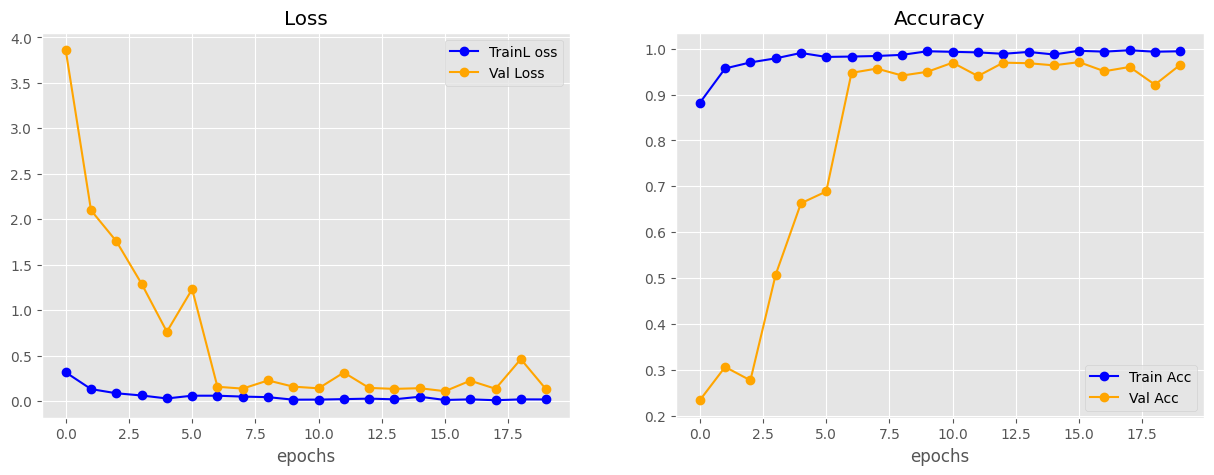

In [ ]:
plot_curves(resnet_history)

In [ ]:
loss, accuracy = model_resnet.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9615 - loss: 0.0954
Test Loss: 0.05764
Test Accuracy: 0.97712


41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step
Classification Report for <Functional name=functional_23, built=True>:
              precision    recall  f1-score   support

   pituitary       1.00      0.93      0.96       300
     notumor       0.93      0.98      0.96       306
  meningioma       0.99      1.00      0.99       405
      glioma       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



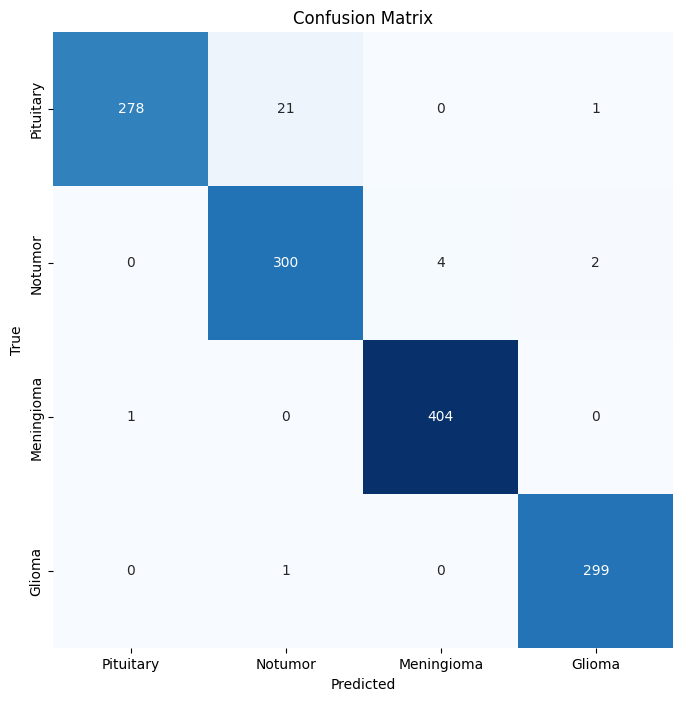

In [ ]:
# Plotting confusion matrix
confusion_matrix = CM(model=model_resnet, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

{'pituitary': 99.619, 'notumor': 0.221, 'meningioma': 0.037, 'glioma': 0.124}
{'pituitary': 99.999, 'notumor': 0.001, 'meningioma': 0.0, 'glioma': 0.0}
{'pituitary': 0.001, 'notumor': 99.999, 'meningioma': 0.0, 'glioma': 0.0}
{'pituitary': 0.001, 'notumor': 99.999, 'meningioma': 0.0, 'glioma': 0.0}
{'pituitary': 0.0, 'notumor': 100.0, 'meningioma': 0.0, 'glioma': 0.0}
{'pituitary': 0.0, 'notumor': 96.761, 'meningioma': 3.239, 'glioma': 0.0}
{'pituitary': 99.999, 'notumor': 0.0, 'meningioma': 0.0, 'glioma': 0.0}
{'pituitary': 99.999, 'notumor': 0.0, 'meningioma': 0.001, 'glioma': 0.0}
{'pituitary': 0.0, 'notumor': 100.0, 'meningioma': 0.0, 'glioma': 0.0}
{'pituitary': 0.0, 'notumor': 100.0, 'meningioma': 0.0, 'glioma': 0.0}


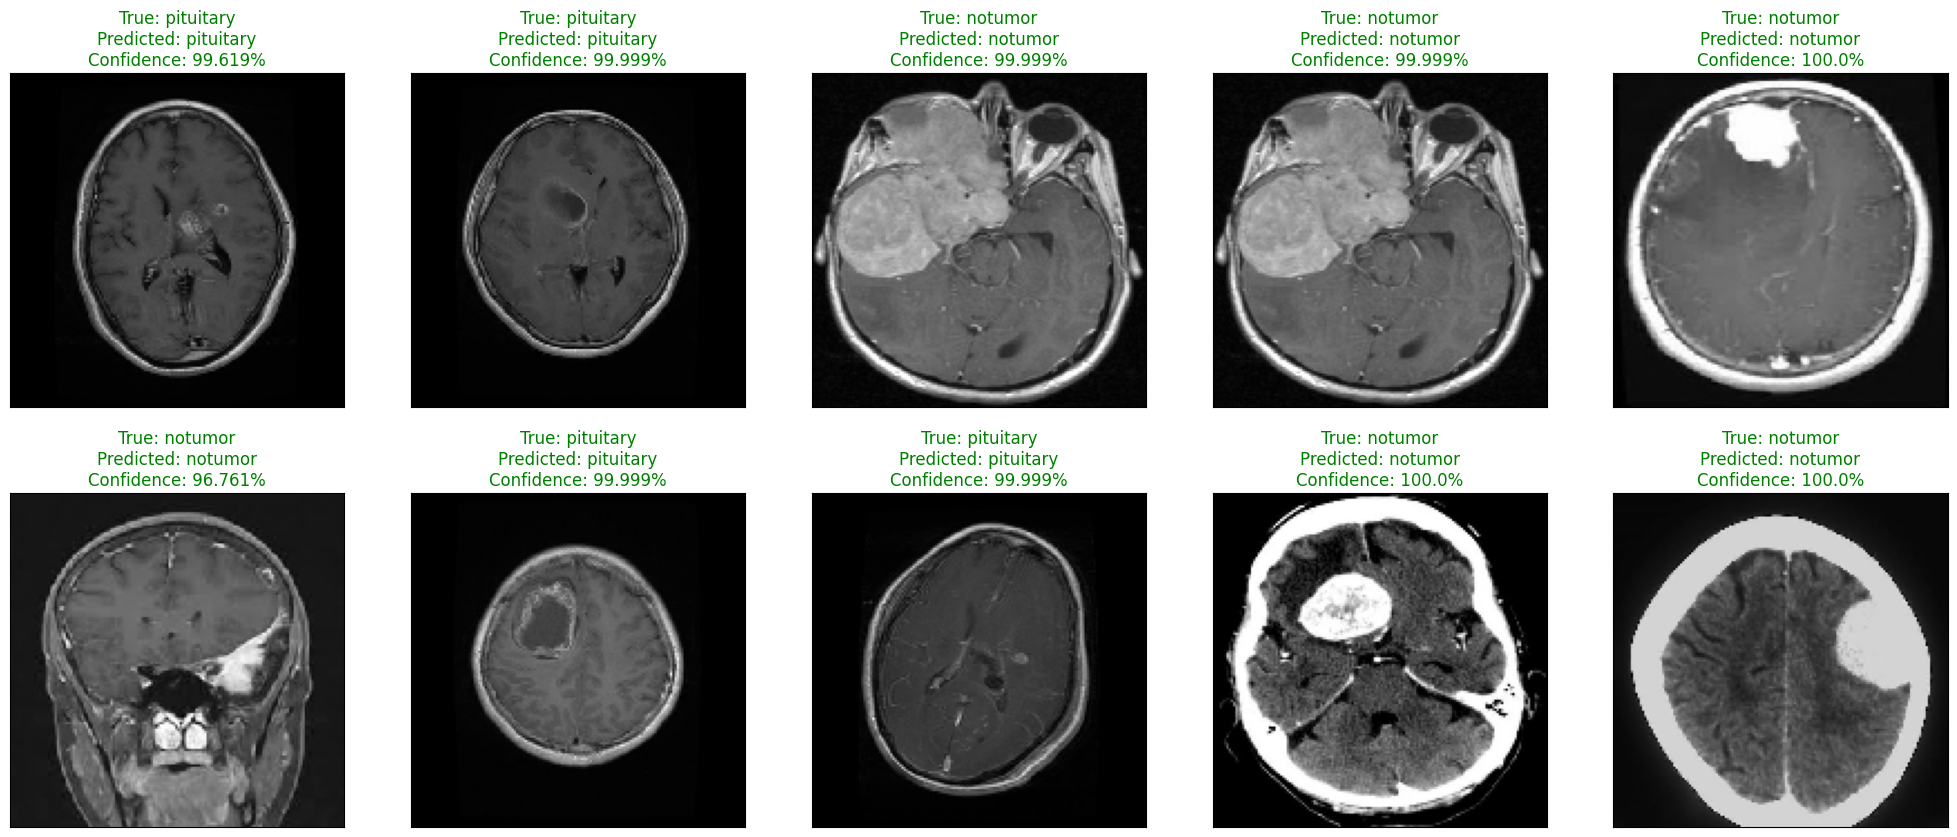

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures predictions from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator))

Random_Img_Index = np.random.randint(0, batch_size , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Predictions = model_resnet.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0)

    Model_Highest_Prediction = np.argmax(Model_Predictions)

    Model_Predictions_Map = { c: round(p*100,3) for (c,p) in zip (classes, Model_Predictions.tolist()[0] ) }

    ax.imshow(Random_Img)

    Pred_Class = classes[Model_Highest_Prediction]

    if classes[Random_Img_Label] == Pred_Class:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {classes[Random_Img_Label]}\nPredicted: {Pred_Class}\nConfidence: {Model_Predictions_Map[Pred_Class]}%",
          color=color)
    print(Model_Predictions_Map)
plt.show()
plt.tight_layout()

# Average/Sum Ensemble

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
#model_path = CNN_model
model1 = load_model('cnn_model.h5')
model2 = load_model('model_vgg.h5')
model3 = load_model('model_resnet.h5')

models = [model1, model2, model3]

preds = [model.predict(test_generator) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict(test_generator)
Pred_classes_1 = np.argmax(prediction1,axis=1)

prediction2 = model2.predict(test_generator)
Pred_classes_2 = np.argmax(prediction2,axis=1)

prediction3 = model3.predict(test_generator)
Pred_classes_3 = np.argmax(prediction3,axis=1)

true_categories = test_generator.classes

accuracy1 = accuracy_score(true_categories, Pred_classes_1)
accuracy2 = accuracy_score(true_categories, Pred_classes_2)
accuracy3 = accuracy_score(true_categories, Pred_classes_3)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
# print('Accuracy Score for model4 = ', accuracy4)

ensemble_accuracy = accuracy_score(true_categories, ensemble_prediction)


print('Accuracy Score for average ensemble = ', ensemble_accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
Accuracy Score for model1 =  0.9786422578184591
Accuracy Score for model2 =  0.9832189168573608
Accuracy Score for model3 =  0.977116704805492
Accuracy Score for average ensemble =  0.9893211289092296


# Weighted Average Ensemble

In [ ]:
weights = [0.3, 0.4, 0.5]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(true_categories, weighted_ensemble_prediction)

In [ ]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)

print('Accuracy Score for average ensemble = ', ensemble_accuracy*100)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy*100)

Accuracy Score for model1 =  0.9786422578184591
Accuracy Score for model2 =  0.9832189168573608
Accuracy Score for model3 =  0.977116704805492
Accuracy Score for average ensemble =  98.93211289092297
Accuracy Score for weighted average ensemble =  98.93211289092297


# Grid search for the best combination of w1, w2, w3 that gives maximum acuracy

In [ ]:
preds1 = [model.predict(test_generator) for model in models]
preds1=np.array(preds1)


import pandas as pd

df = pd.DataFrame([])

for w1 in range(0, 9):
    for w2 in range(0, 9):
        for w3 in range(0, 9):
                wts = [w1/10., w2/10., w3/10.]
                wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
                wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
                weighted_accuracy = accuracy_score(true_categories, wted_ensemble_pred)
                df = pd.concat([df, pd.DataFrame.from_records([{'wt1':wts[0], 'wt2':wts[1], 'wt3':wts[2],
                             'acc':weighted_accuracy*100}],index=[0])], ignore_index=True)


max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3],
      "obained with w1 = ", max_acc_row[0],
      ", w2 = ", max_acc_row[1],
      " and w3 = ", max_acc_row[2])

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
Max accuracy of  99.16094584286805 obained with w1 =  0.3 , w2 =  0.3  and w3 =  0.1


## Explore metrics for the ideal weighted ensemble model

              precision    recall  f1-score   support

   pituitary       1.00      0.97      0.98       300
     notumor       0.97      0.99      0.98       306
  meningioma       0.99      1.00      1.00       405
      glioma       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



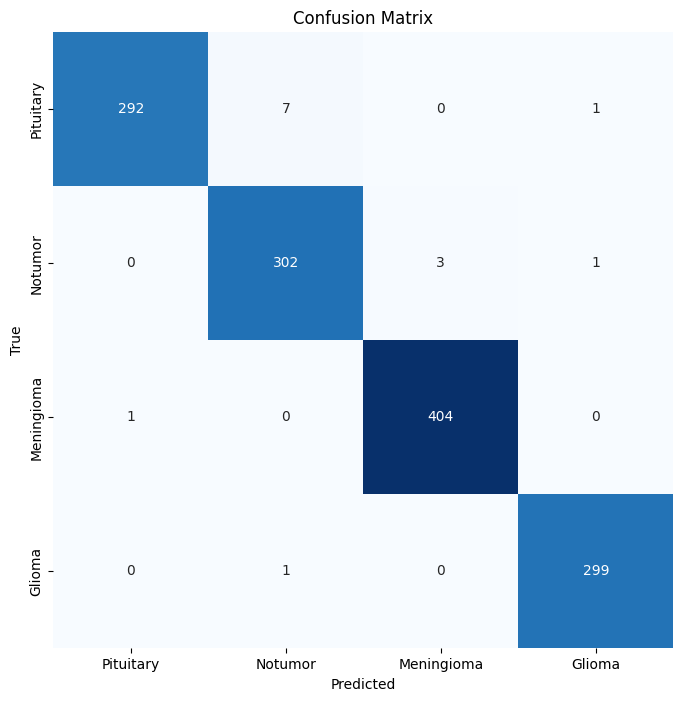

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

ideal_weighted_ensemble_preds = np.tensordot(preds, weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_ensemble_preds, axis=1)

#Print confusion matrix
confusion_matrix = confusion_matrix(true_categories, ideal_weighted_ensemble_prediction)

print(classification_report(true_categories, ideal_weighted_ensemble_prediction,target_names = ['pituitary', 'notumor', 'meningioma', 'glioma']))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()



